Following code is adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [18]:
# Import packages
import torch
import torchvision
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset 
from torch.utils.data.dataloader import default_collate
from torch.utils.data import Dataset
import torch.optim as optim
import time
import glob 
import numpy as np
import collada
from __future__ import print_function, division
import torch.nn as nn
from torch.autograd import Variable
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [19]:
# CONFIG #
# Adapted from Assignment 2 codebase

# TRAINING SETTINGS
NUM_EPOCHS = 7


# LEARNING RATE SETTINGS
BASE_LR = 0.01 # originally 0.001
DECAY_WEIGHT = 0.0001  # factor by which the learning rate is reduced; originally 0.1
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_CLASSES = 10 # set the number of classes in your dataset
DATA_DIR = 'CIFAR-10' # to run with the sample dataset, just set to 'hymenoptera_data'


# DATALOADER PROPERTIES
BATCH_SIZE = 128 # originally 10


# GPU SETTINGS
#TORCH_DEVICE = 'mps:0' # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
device = torch.device("mps")
GPU_MODE = 1 # set to 1 if want to run on gpu.


# SETTINGS FOR DISPLAYING ON TENSORBOARD
USE_TENSORBOARD = 0 #if you want to use tensorboard set this to 1.
TENSORBOARD_SERVER = "YOUR TENSORBOARD SERVER ADDRESS HERE" # If you set.
EXP_NAME = "fine_tuning_experiment" # if using tensorboard, enter name of experiment you want it to be displayed as.


In [20]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [21]:
# Input the correct link for CIFAR10 dataset (otherwise odwnload doesn't work)
torchvision.datasets.CIFAR10.url="http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

In [22]:
# Define transformations for training and validation
# Adapted from Assignment 2 codebase

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(224),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(72),  # Slightly larger for random cropping
        transforms.RandomCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}



In [23]:
# Define datasets
# Source: GPT (prompt: how to fix default-collate error from model definition code)

full_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train']) # Not sure how to implement validation transforms
train_indices, val_indices = random_split(range(len(full_trainset)), [45000, 5000]) # Create subset datasets with correct transforms 
trainset = Subset(full_trainset, train_indices) 
valset = Subset(full_trainset, val_indices) # Store in dictionary 
dsets = {'train': trainset, 'val': valset}

# Get dataset sizes
dset_sizes = {'train': len(dsets['train']), 'val': len(dsets['val'])}

# Define DataLoaders
dset_loaders = {
    'train': DataLoader(dsets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(dsets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

In [24]:
# # Define the CNN; note: code from Assignment 2

# import torch.nn as nn
# from collections import OrderedDict

# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(SimpleCNN, self).__init__()
#         self.num_classes = num_classes
#         self.model = nn.Sequential(OrderedDict([
#             ('conv1', nn.Conv2d(3,224,1)),
#             ('relu1', nn.ReLU()),
#             ('pool1', nn.AvgPool2d(4)),
#             ('conv2', nn.Conv2d(224,32,1)),
#             ('relu2', nn.ReLU()),
#             ('pool2', nn.AvgPool2d(16)),
#             ('flatten', nn.Flatten()),
#             ('fc', nn.Linear(288,num_classes)),
#         ]))

#     def forward(self, x):
#         return self.model(x).to(device)

In [25]:
# # Define model
# # Source: https://www.kaggle.com/code/datascienceimcomming/cifar10-with-cnn-90-accuracy

class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=3, 
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=3, 
            out_channels=3, 
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True)
    ]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Model(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(
            conv_block(128, 128), 
            conv_block(128, 128)
        )
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(
            conv_block(512, 512), 
            conv_block(512, 512)
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [26]:
# Import pertinent packages
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import copy
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [27]:
# Define GPU use
use_gpu = GPU_MODE

In [28]:
import time
import torch
import copy

def train_model(model, criterion, optimizer, lr_scheduler, num_epochs):
    since = time.time()

    best_model = model.to(device)
    best_acc = 0.0

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to eval mode for validation (no need to track gradients)

            running_loss = 0.0
            running_corrects = 0

            counter = 0
            # Iterate over data, getting one batch of inputs (images) and labels each time.
            for inputs, labels in dset_loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                # Print a line every 10 batches so you have something to watch and don't feel like the program isn't running.
                if counter % 10 == 0:
                    print("Reached batch iteration", counter)

                counter += 1

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Update running loss and correct predictions
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            # Calculate loss and accuracy for this epoch
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)

            # Deep copy the model if it improves accuracy
            if phase == 'val':
                if USE_TENSORBOARD:
                    foo.add_scalar_value('epoch_loss', epoch_loss, step=epoch)
                    foo.add_scalar_value('epoch_acc', epoch_acc, step=epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    print('new best accuracy =', best_acc)

        # End of epoch — free MPS memory if needed
        if device.type == 'mps':
            torch.mps.empty_cache()

    # Training time
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return best_model, accuracies, losses


In [29]:
# # Define function for modifying learning rate

def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [30]:
# Define model architecture
# From same source as earlier: https://www.kaggle.com/code/datascienceimcomming/cifar10-with-cnn-90-accuracy

model_ft = models.resnet18(pretrained=True)
# model_ft = Model(3, 10)

# Modify the first convolutional layer
model_ft.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_ft.maxpool = nn.Identity()  # Remove the max pooling layer to preserve resolution
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.to(device)
    model_ft.to(device)

#optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.01) # originally lr=0.0001
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)

/opt/homebrew/Caskroom/miniforge/base/envs/NB240/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/NB240/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# Run the functions and save the best model in the function model_ft.
model_ft_6, accuracies_6, losses_6 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs= NUM_EPOCHS)

----------
Epoch 0/6
----------
LR is set to 0.01
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch iteration 110
Reached batch iteration 120
Reached batch iteration 130
Reached batch iteration 140
Reached batch iteration 150
Reached batch iteration 160
Reached batch iteration 170
Reached batch iteration 180
Reached batch iteration 190
Reached batch iteration 200
Reached batch iteration 210
Reached batch iteration 220
Reached batch iteration 230
Reached batch iteration 240
Reached batch iteration 250
Reached batch iteration 260
Reached batch iteration 270
Reached batch iteration 280
Reached batch iteration 290
Reached batch iteration 300
Reached batch iteration 310
Reached batch iteration 320
Reached batch iteration 330
Reached b

In [32]:
# Define path to save models 

path_to_set = "/Users/ellacho/Documents/NB240" # paste path here
os.chdir(path_to_set)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/ellacho/Documents/NB240


In [33]:
# Save trained model

# Save model
# batch 5 epoch 5
# torch.save(model_ft.state_dict(), 'CIFAR10_train_val.pt')

# batch 10 epoch 5
# torch.save(model_ft_2.state_dict(), 'CIFAR10_train_val_2.pt')

# batch 10 epoch 7, SimpleCNN architecture
# torch.save(model_ft_3.state_dict(), 'CIFAR10_train_val_3.pt')
# 
# batch 10 epoch 5, cited architecture
# torch.save(model_ft_4.state_dict(), 'CIFAR10_train_val_4.pt')

# batch 128 epochs 5, pretrained RESNET18 + base lr 0.01; decay weight 0.0001; lr=1e-4)
# torch.save(model_ft_5.state_dict(), 'CIFAR10_train_val_5.pt')

# batch 128 epochs 7, pretrained RESNET18 + base lr 0.01; decay weight 0.0001; lr=1e-4)
torch.save(model_ft_6.state_dict(), 'CIFAR10_train_val_6.pt')

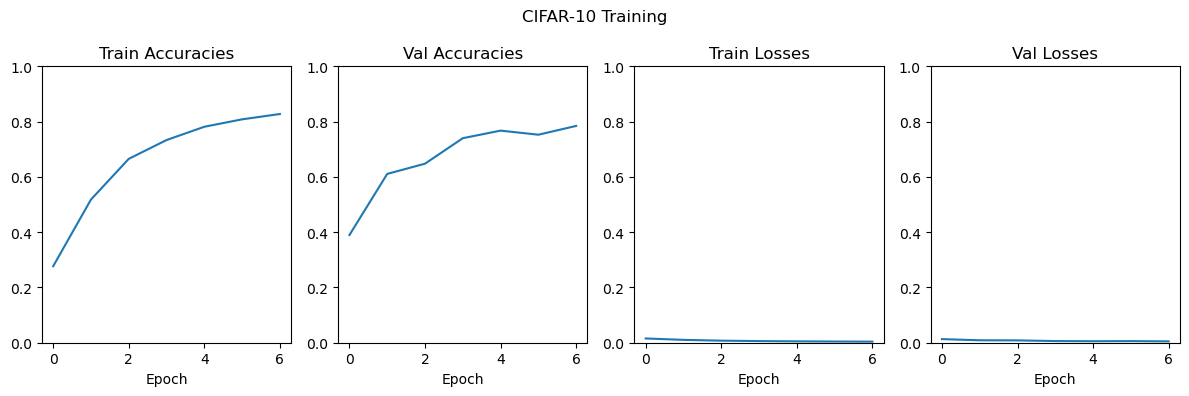

In [34]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize = (12,4))
fig.suptitle("CIFAR-10 Training", fontsize=12) 

ax[0].plot(accuracies_6['train'])
ax[0].set_title('Train Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(0, 1)

ax[1].plot(accuracies_6['val'])
ax[1].set_title('Val Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0, 1)

ax[2].plot(losses_6['train'])
ax[2].set_title('Train Losses')
ax[2].set_xlabel('Epoch')
ax[2].set_ylim(0, 1)

ax[3].plot(losses_6['val'])
ax[3].set_title('Val Losses')
ax[3].set_xlabel('Epoch')
ax[3].set_ylim(0, 1)

plt.tight_layout()

plt.savefig("CIFAR10_6.png", dpi=300)

plt.show()